In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.options.display.max_rows = 200
pd.options.display.max_columns = 50
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
mapping_report = '38_mapping.tsv'
qc_report = '38_qc.tsv'
imputation_experiments = 'imputation_experiments.tsv'

In [3]:
# Load ChIP-seq mapping and qc report for 38/19.
mdf = pd.read_table(mapping_report)
qdf = pd.read_table(qc_report)

# Load imputation experiments for filtering.
idf = pd.read_table(imputation_experiments, header=None)

In [4]:
mdf.shape

(9494, 41)

In [5]:
idf.shape

(595, 8)

In [6]:
# Select accessions of ChIP-seq imputation experiments.
imputation_accessions = list(idf[idf[4] == 'ChIP-seq'][[3]].dropna()[3].values)
len(imputation_accessions)

425

In [7]:
# Filter results that don't have usable_frags metric
mdf = mdf[~mdf.usable_frags.isnull()].reset_index(drop=True)

# Convert usuable_frags to numeric
mdf.usable_frags = pd.to_numeric(mdf.usable_frags.apply(lambda x: x.replace(',', '')))

# Filter to histone experiments.
mdf = mdf[mdf.target_type.str.contains('histone')].reset_index(drop=True)

In [8]:
mdf.shape

(3354, 41)

In [9]:
# Filter to imputation experiments.
mdf = mdf[mdf.experiment.isin(imputation_accessions)].reset_index(drop=True)

# Make sure mapping report includes all imputation accessions.
assert len(set(imputation_accessions) - set(mdf.experiment)) == 0

In [10]:
mdf.shape

(693, 41)

In [11]:
# File count by mark
mdf.target.value_counts()

H3K4me3-human      92
H3K36me3-human     73
H3K4me1-human      61
H3K27me3-human     61
H3K27ac-human      56
H3K9me3-human      54
H3K9ac-human       35
H3K4me2-human      22
H2AFZ-human        22
H3K79me2-human     21
H4K20me1-human     15
H2AK5ac-human      14
H4K8ac-human       14
H2BK5ac-human      13
H2BK12ac-human     13
H3K18ac-human      13
H3K4ac-human       13
H3K14ac-human      12
H3K79me1-human     12
H3K23ac-human      12
H2BK120ac-human    11
H2BK15ac-human     10
H4K91ac-human       9
H3K56ac-human       7
H4K5ac-human        6
H2BK20ac-human      5
H3K23me2-human      4
H4K12ac-human       3
H3K9me1-human       3
H3K9me2-human       2
H3F3A-human         2
H2AK9ac-human       2
H3T11ph-human       1
Name: target, dtype: int64

In [12]:
def make_boxen_plot(title=None, sci_notation=False, sci_axis='x', **kwargs):
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=[17, 10])
    ax = sns.boxenplot(
        **kwargs
    )
    if title:
        fig.suptitle(title, size=16, y=0.904)
    if not sci_notation:
        plt.ticklabel_format(style='plain', axis=sci_axis)
        if sci_axis == 'x':
            gax = ax.get_xaxis()
        else:
            gax = ax.get_yaxis()
        gax.set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
        )
    plt.xticks(rotation=45)

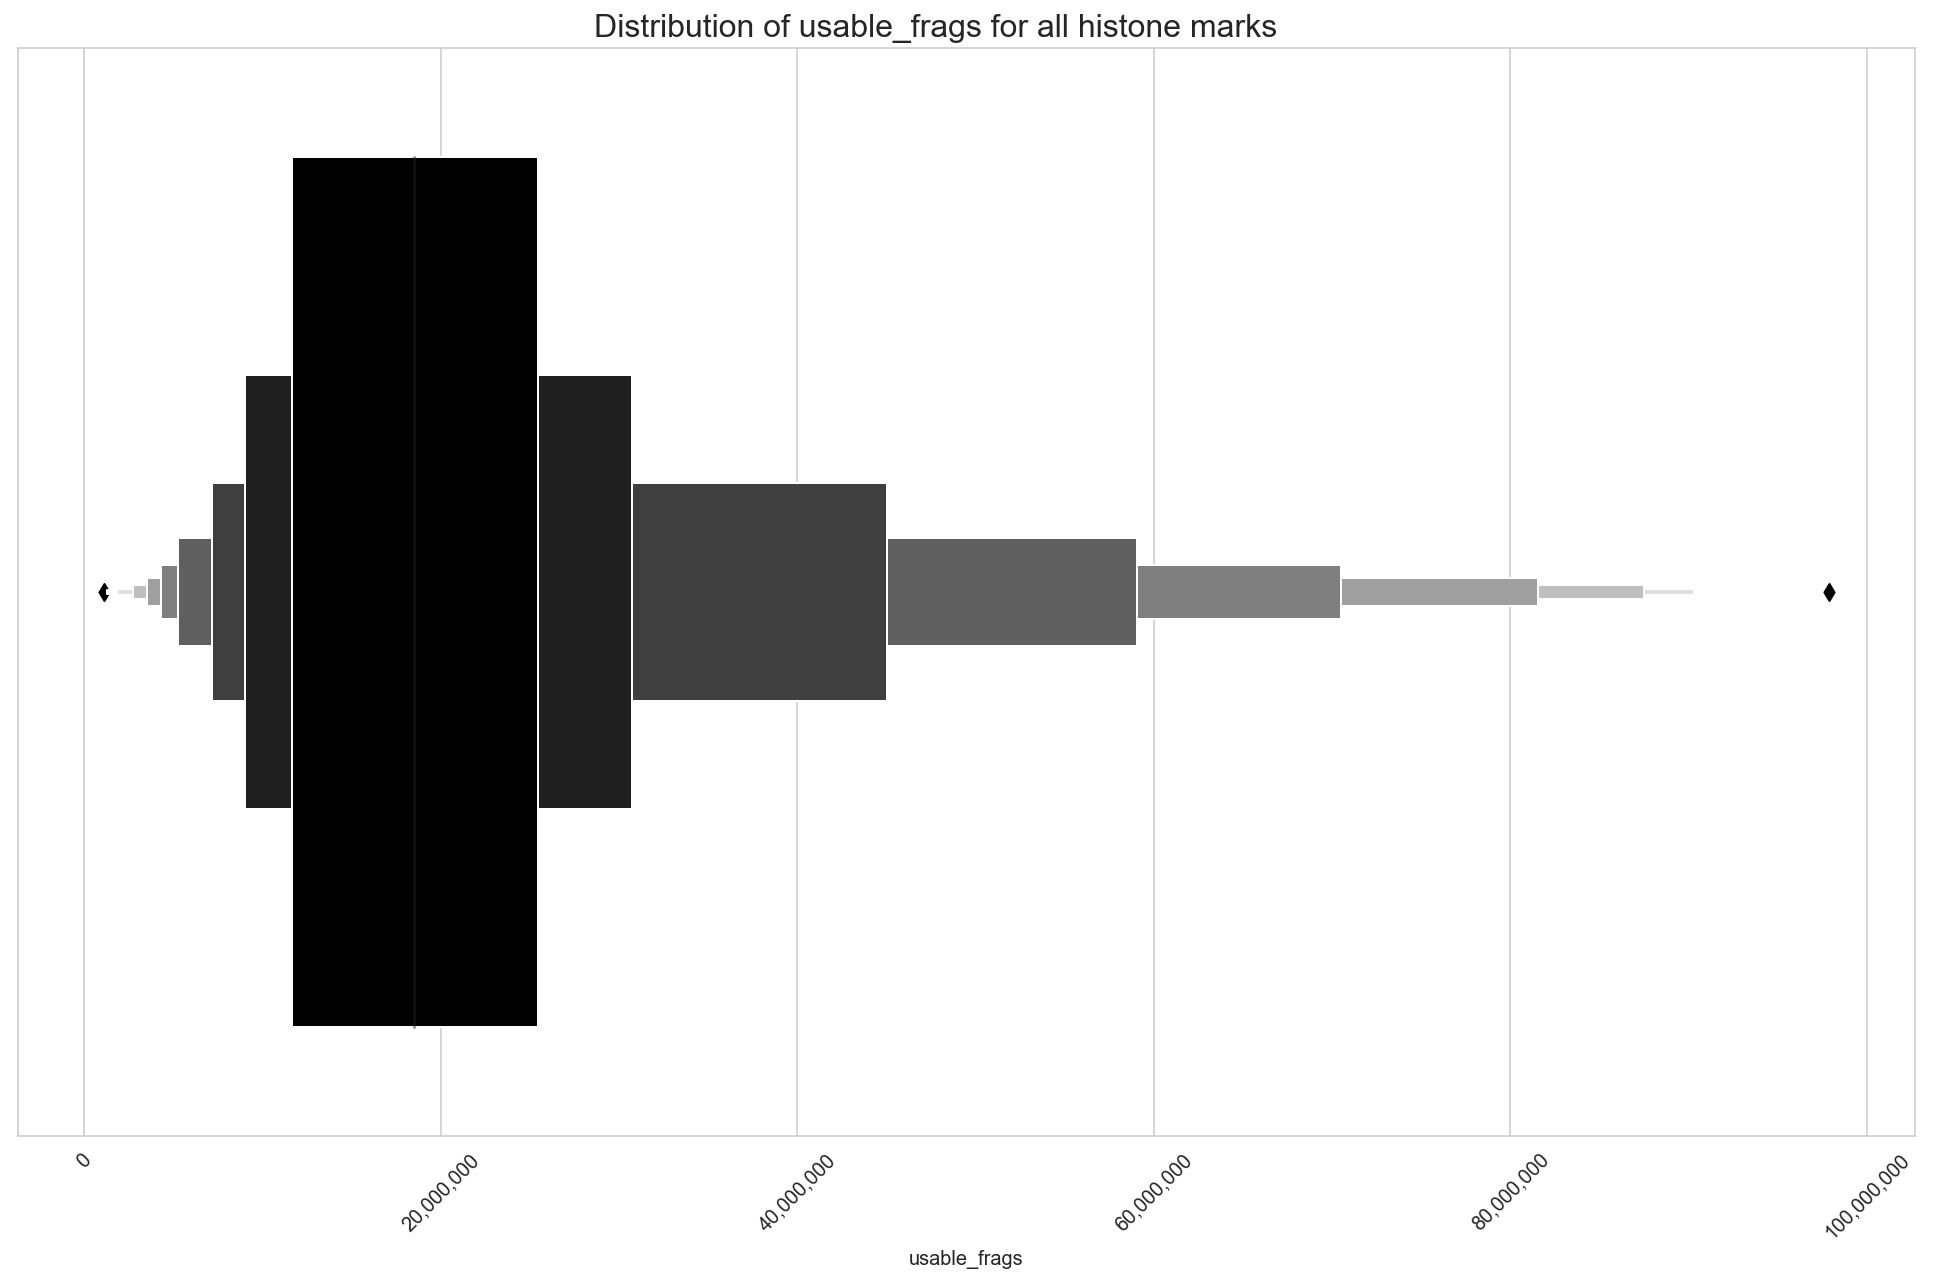

In [13]:
make_boxen_plot(data=mdf, x=mdf.usable_frags, title='Distribution of usable_frags for all histone marks', color='black')

In [14]:
core_marks = [
    'H3K4me1-human',
    'H3K4me3-human',
    'H3K27me3-human',
    'H3K27ac-human',
    'H3K36me3-human',
    'H3K9me3-human'
]

In [15]:
# Only keep core targets
core_mdf = mdf[mdf.target.isin(core_marks)].reset_index(drop=True)

# Use ranking as sort order later
sort_order = list(core_mdf.target.value_counts().index)

# Files by core mark
core_mdf.target.value_counts()

H3K4me3-human     92
H3K36me3-human    73
H3K4me1-human     61
H3K27me3-human    61
H3K27ac-human     56
H3K9me3-human     54
Name: target, dtype: int64

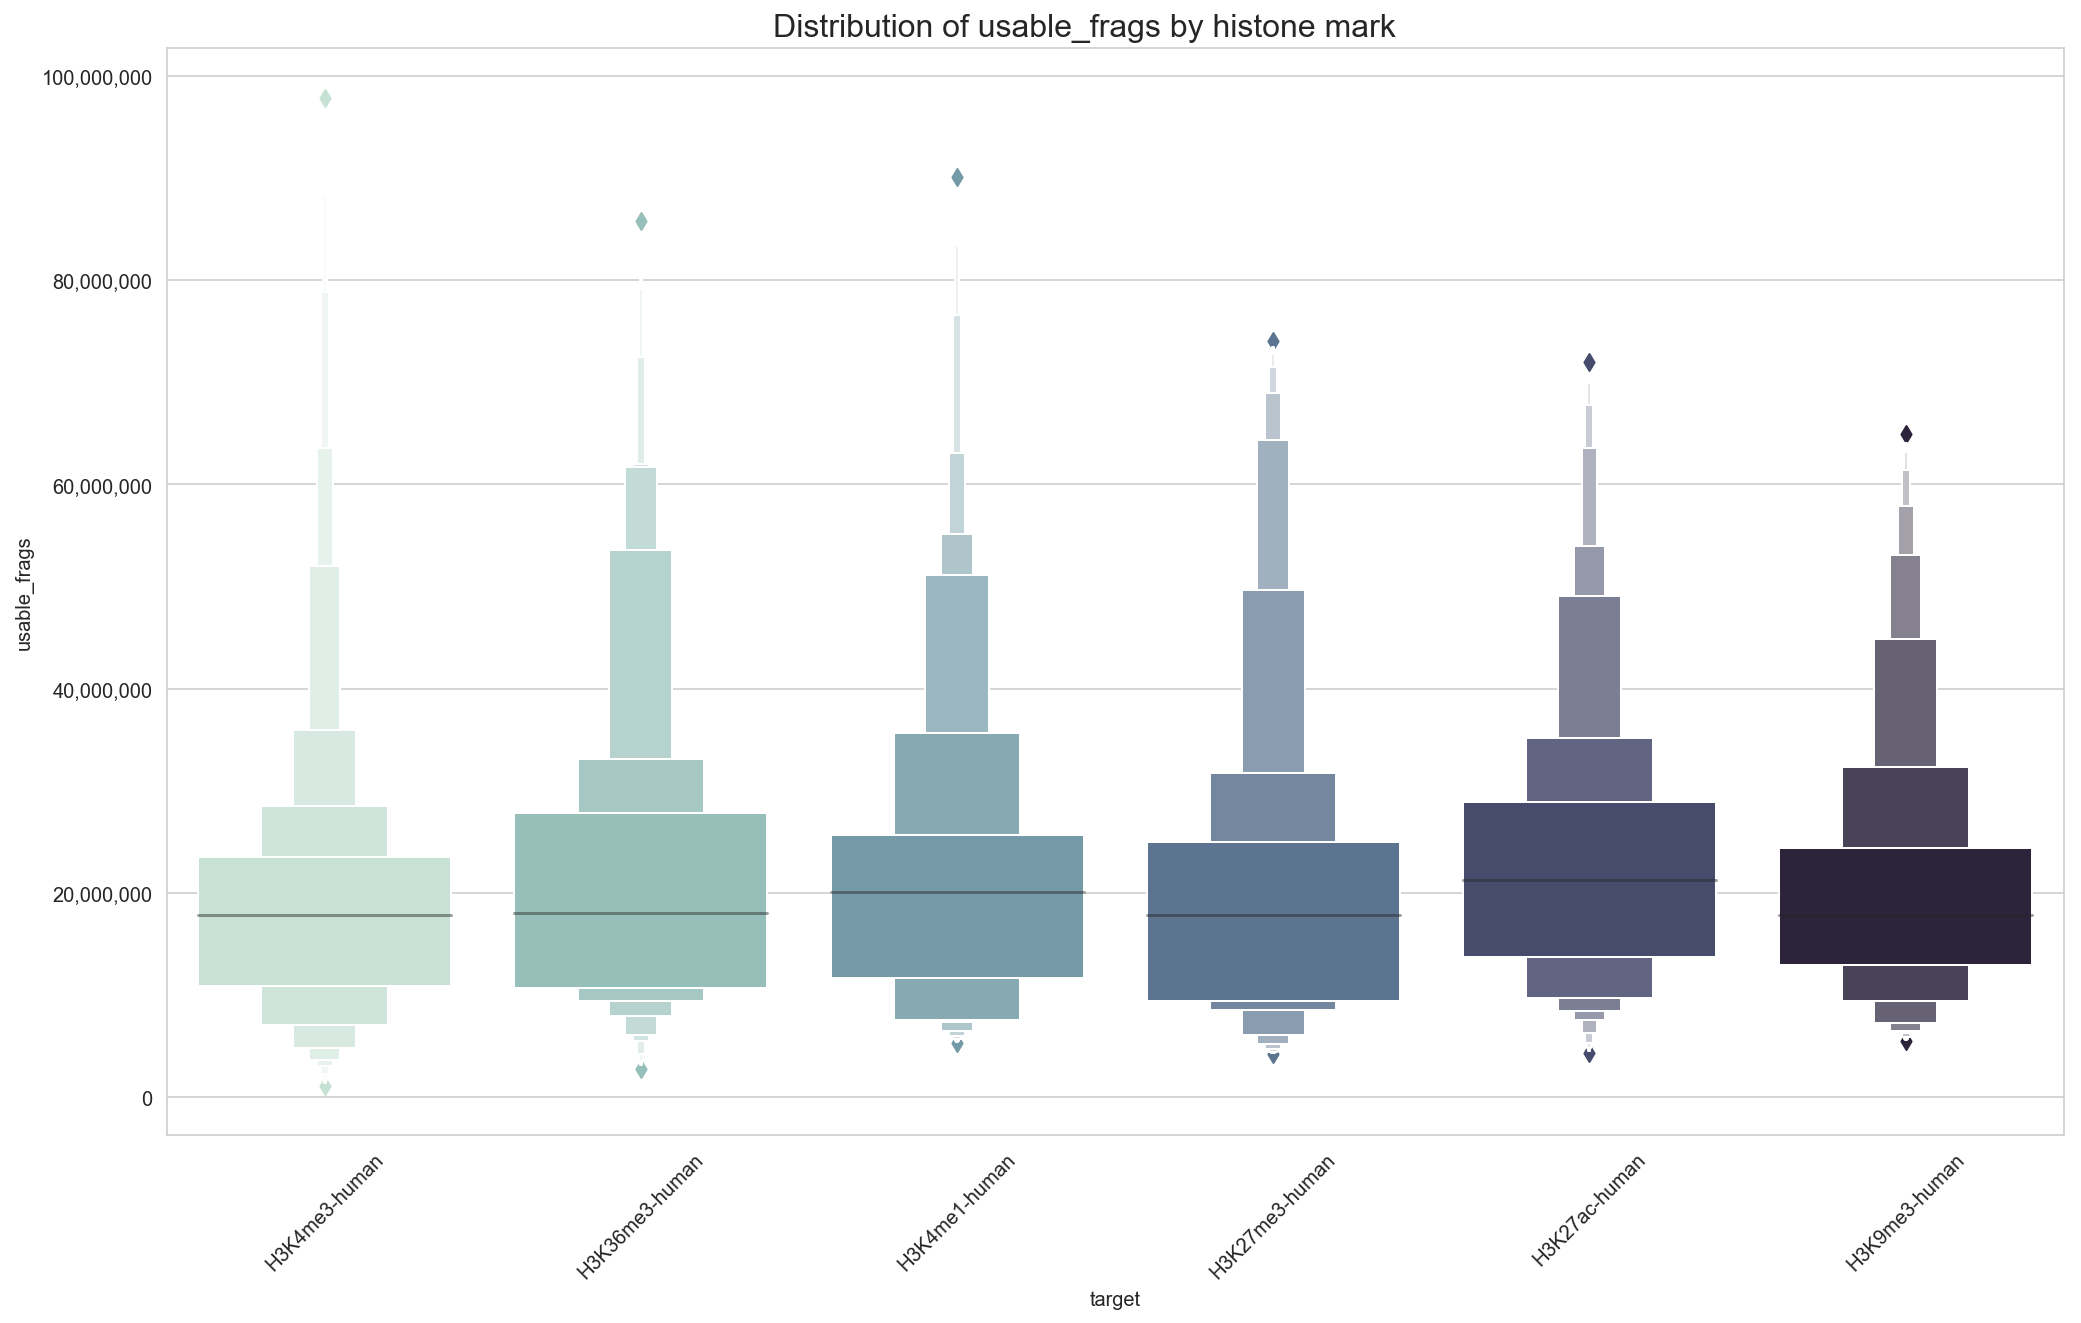

In [16]:
make_boxen_plot(
    data=core_mdf,
    x='target',
    y='usable_frags',
    title='Distribution of usable_frags by histone mark',
    palette=sns.cubehelix_palette(6, start=0.3, rot=-0.44),
    sci_axis='y',
    order=sort_order
)

In [17]:
# File count by biosample_type and core mark
pd.pivot_table(columns='target', index='biosample_type', values='bam', aggfunc='count', data=core_mdf)[sort_order]

target,H3K4me3-human,H3K36me3-human,H3K4me1-human,H3K27me3-human,H3K27ac-human,H3K9me3-human
biosample_type,,,,,,
cell line,44,32,27,27,18,19
in vitro differentiated cells,10,11,10,13,8,11
primary cell,16,10,9,10,6,11
tissue,22,20,15,11,24,13


In [18]:
# File count by biosample_name and core mark
pd.pivot_table(columns='target', index='biosample_name', values='bam', aggfunc='count', data=core_mdf).fillna(0)[sort_order]

target,H3K4me3-human,H3K36me3-human,H3K4me1-human,H3K27me3-human,H3K27ac-human,H3K9me3-human
biosample_name,,,,,,
BE2C,2.0,0.0,0.0,0.0,0.0,0.0
"CD4-positive, alpha-beta memory T cell",5.0,4.0,4.0,4.0,3.0,4.0
Caco-2,2.0,2.0,0.0,2.0,0.0,0.0
DND-41,4.0,2.0,2.0,2.0,2.0,2.0
ES-I3,0.0,2.0,2.0,0.0,0.0,2.0
GM06990,2.0,2.0,0.0,2.0,0.0,0.0
H1-hESC,10.0,8.0,7.0,9.0,4.0,6.0
H9,4.0,4.0,4.0,4.0,2.0,3.0
HL-60,2.0,0.0,0.0,0.0,0.0,0.0
